## CUSTOMER SEGMENTATION

Firstly, declaring necessary libraries

In [1]:
# for data analysis
import pandas as pd
import numpy as np

import json     # for reading the key inside the json formatted file

# for data visualization
import matplotlib.pyplot as plt

import pyodbc   # for connecting database

> Connecting to Database

Pyodbc library handles the connection between Jupyter notebook and MS SQL Server. SQL Server's key is hidden inside the json file.

In [2]:
f = open('log.json')
sql_key = json.load(f)     # returns JSON object as a dictionary

cnxn = pyodbc.connect(sql_key['key'])     # establish a connection
crsr = cnxn.cursor()                      # cursor enables to send command

> Sending Queries 

Queries are sent with respect to the decisions given on analytics phase. G and T type company data are retrieved separately.

>> For G (Şahıs)

In [3]:
gk_query= """SELECT MUSTERI_ID, ID, CEK_NO, CEK_TUTAR, VADE_GUN, BK_LIMIT, BK_RISK,
            BK_GECIKMEHESAP, BK_GECIKMEBAKIYE
            FROM dbo.dataset
            WHERE SIRKET_TURU LIKE 'G' """

g_company_type_df = pd.read_sql(gk_query, cnxn)

C:\Users\emirh\AppData\Local\Temp\ipykernel_15404\1577447570.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  g_company_type_df = pd.read_sql(gk_query, cnxn)


In [27]:
g_company_type_df.head(10)

,MUSTERI_ID,ID,CEK_NO,CEK_TUTAR,VADE_GUN,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE
0,11800527,2457932,70331933,20000,100,0,0,0,0
1,12024009,2457933,3014103,25000,126,2213,226,2,1012
2,11800527,2457934,7031933,20000,100,0,0,0,0
3,11724283,2457936,7198012,23000,151,52100,9481,3,3575
4,11879266,2457937,9090937,10000,151,280101,211301,3,4128
5,11879266,2457938,9090936,13458,121,280101,211301,3,4128
6,11854083,2457939,4535918,5200,4,0,0,0,0
7,11654711,2457942,88624,110000,181,215261,150619,1,847
8,11723432,2457943,3331313,5300,121,104384,65599,3,2591
9,11577211,2457944,4602258,11000,187,215860,85589,4,6379


>> For T (Tüzel)

In [31]:
tk_query= """SELECT MUSTERI_ID, ID, CEK_NO, CEK_TUTAR, VADE_GUN, TK_NAKDILIMIT, TK_NAKDIRISK, TK_GAYRINAKDILIMIT, TK_GAYRINAKDIRISK, TK_GECIKMEHESAP, TK_GECIKMEBAKIYE FROM dbo.dataset WHERE SIRKET_TURU LIKE 'T' """
t_company_type_df = pd.read_sql(tk_query, cnxn)

C:\Users\emirh\AppData\Local\Temp\ipykernel_18068\595317809.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  t_company_type_df = pd.read_sql(tk_query, cnxn)


### MACHINE LEARNING

The ML is going to be implemented to segment customer portfolio into clusters based on their risks. Firstly, the customer portfolio divided into two groups: T type and G type customers. Due to the differences between their attributes, this was inevitable step to be done. Also, it is crucial to define type of machine learning. Due to the attributes, it will be unsupervised learning. As observed, all attributes will be used are features. For providing accurate solution, we obtained that classification of the customer portfolio is a must requirements. In this sense, **K-means** is going to implemented.

Next, the datasets will be prepared for the clustering. There is a need of deriving new attributes by using existing ones. Thus, the feature extraction must be done before putting data into model. In addition to this, data scaling is another significant task to complete. According to Dong, Zhang, and Chen (2020), *data scaling is a technique used in machine learning to adjust the range of features in a dataset, typically to a common scale between zero and one or -1 and 1.* The purpose of data scaling is to standardize the data, mitigate the impact of outliers, and ensure that all features are treated equally during model training. As stated in the paper, we are looking forward to handle large range of magnitudes with this method.

Also, data will be divided into two as training and test for ML. Sarkar and Bali (2020) stated that training dataset is used to teach the algorithm to recognize patterns in the data, while the testing dataset is used to evaluate the algorithm's ability to generalize to new data. We are going to determine whether the model is good fit or not by using test dataset. It is a common fact that overfitting or underfitting models my occur during ML researches.

Moreover, the optimal number of clusters are going to be obtained by using Elbow Method from the data. The elbow method is a critical technique for selecting the optimal number of clusters in k-means clustering, as it provides an objective way to determine the appropriate number of clusters and helps to prevent overfitting and improve the interpretability of the resulting clusters (Tang & Zhang, 2019). After this, we are going to train the model with the train dataset.

After these steps, the accuracy of K-means model must be found out. Also, other appropriate unsupervised ML modelling techniques are going to be compared. The most fitting model's results are going to be saved into the database. The database is going to be integrated our data-oriented web application for strong Business Intelligence presentation.

To conclude, our steps are;

*   Feature Extraction
*   Scaling Data
*   Training/Test Set Division
*   Elbow Method
*   Accuracy Calculation
*   Comparing K-means with Other Models
*   Saving Results into Database
*   Presenting Results via Streamlit Web-App

> Handle Data Types

For G type Customers first

Firstly, we have to assign data types before ML operations

In [28]:
g_company_type_df.info()    # to see the data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229538 entries, 0 to 229537
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   MUSTERI_ID        229538 non-null  object
 1   ID                229538 non-null  int64 
 2   CEK_NO            229538 non-null  object
 3   CEK_TUTAR         229538 non-null  object
 4   VADE_GUN          229538 non-null  object
 5   BK_LIMIT          229538 non-null  object
 6   BK_RISK           229538 non-null  object
 7   BK_GECIKMEHESAP   229538 non-null  object
 8   BK_GECIKMEBAKIYE  229538 non-null  object
dtypes: int64(1), object(8)
memory usage: 15.8+ MB


In [29]:
# there are several characters in the MUSTERI_ID column, so we need to remove them
g_company_type_df['MUSTERI_ID']=g_company_type_df['MUSTERI_ID'].str.replace(r'\D', '').astype(int)
g_company_type_df['ID']=g_company_type_df['ID'].astype(int)

# VADE_GUN represents the amount of day, so it is an integer
g_company_type_df['VADE_GUN']=g_company_type_df['VADE_GUN'].astype(int)
g_company_type_df['CEK_TUTAR']=g_company_type_df['CEK_TUTAR'].replace(',','.', regex=True).astype(float)

# converting into float to use on ML model later
g_company_type_df['BK_LIMIT']=g_company_type_df['BK_LIMIT'].astype(float)
g_company_type_df['BK_RISK']=g_company_type_df['BK_RISK'].astype(float)
g_company_type_df['BK_GECIKMEHESAP']=g_company_type_df['BK_GECIKMEHESAP'].astype(float)
g_company_type_df['BK_GECIKMEBAKIYE']=g_company_type_df['BK_GECIKMEBAKIYE'].astype(float)

C:\Users\emirh\AppData\Local\Temp\ipykernel_9688\1768993693.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  g_company_type_df['MUSTERI_ID']=g_company_type_df['MUSTERI_ID'].str.replace(r'\D', '').astype(int)


*CEK_NO* has several improper values, so we need to handle errors and convert it into integer

In [ ]:
# used these queries to spot the non-integer values
"""SELECT [CEK_NO]
FROM [faktoring_db].[dbo].[dataset]
WHERE CEK_NO like '%[^a-Z0-9]%'

SELECT CEK_NO, COUNT(*) as count
FROM [faktoring_db].[dbo].[dataset]
WHERE CEK_NO like '%[^a-Z0-9]%'
GROUP BY CEK_NO
HAVING COUNT(*) > 0

//OR USE THIS, MORE EFFICIENT RESULTS

SELECT [ID],[CEK_NO]
FROM [faktoring_db].[dbo].[dataset]
WHERE ISNUMERIC([CEK_NO]) <> 1;"""

Solved the issue on MS SQL with the following script below:

In [ ]:
#...and solved the issue by using the following queries
"""
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 1
WHERE [ID] = 2770334;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 2
WHERE [ID] = 2494076;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 3
WHERE [ID] = 2501347;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 4
WHERE [ID] = 2551433;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 5
WHERE [ID] = 2551434;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 6
WHERE [ID] = 2633345;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 7
WHERE [ID] = 2689531;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 8
WHERE [ID] = 2699745;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 9
WHERE [ID] = 2703751;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 10
WHERE [ID] = 2715934;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 11
WHERE [ID] = 2828009;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 12
WHERE [ID] = 2828010;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 13
WHERE [ID] = 2828011;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 14
WHERE [ID] = 2828012;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 15
WHERE [ID] = 2828013;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 16
WHERE [ID] = 2516070 OR
	[ID] = 2525905 OR
	[ID] = 2573048 OR
	[ID] = 2685207 OR
	[ID] = 2727249;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 17
WHERE [ID] = 2741161;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 18
WHERE [ID] = 2766289;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 19
WHERE [ID] = 2809942;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 20
WHERE [ID] = 2815551;

UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 21
WHERE [ID] = 2850473;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 22
WHERE [ID] = 2911050;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 23
WHERE [ID] = 2912888;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 24
WHERE [ID] = 2912889;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 25
WHERE [ID] = 2922915;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 26
WHERE [ID] = 2922916;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 27
WHERE [ID] = 2923795;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 28
WHERE [ID] = 2703536;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 29
WHERE [ID] = 2740283;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 30
WHERE [ID] = 2622979;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 31
WHERE [ID] = 2740284;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 32
WHERE [ID] = 2740285;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 33
WHERE [ID] = 2740286;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 34
WHERE [ID] = 2740287;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 35
WHERE [ID] = 2740288;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 36
WHERE [ID] = 2740289;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 37
WHERE [ID] = 2740290;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 38
WHERE [ID] = 2780745;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 39
WHERE [ID] = 2782835;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 40
WHERE [ID] = 2782836;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 41
WHERE [ID] = 2823409;
UPDATE [faktoring_db].[dbo].[dataset]
SET [CEK_NO] = 42
WHERE [ID] = 2823497;
"""

In [30]:
# finally, the script is executed successfully
g_company_type_df['CEK_NO']=g_company_type_df['CEK_NO'].astype('int64')

In [8]:
# checking uniqueness of ID
g_company_type_df['ID'].is_unique   # check if there is any duplicate in ID

True

In [31]:
g_company_type_df.info()    # to see the data types after the changes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229538 entries, 0 to 229537
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MUSTERI_ID        229538 non-null  int32  
 1   ID                229538 non-null  int32  
 2   CEK_NO            229538 non-null  int64  
 3   CEK_TUTAR         229538 non-null  float64
 4   VADE_GUN          229538 non-null  int32  
 5   BK_LIMIT          229538 non-null  float64
 6   BK_RISK           229538 non-null  float64
 7   BK_GECIKMEHESAP   229538 non-null  float64
 8   BK_GECIKMEBAKIYE  229538 non-null  float64
dtypes: float64(5), int32(3), int64(1)
memory usage: 13.1 MB


In [32]:
g_company_type_df.describe()    # to see the statistical summary of the data

,MUSTERI_ID,ID,CEK_NO,CEK_TUTAR,VADE_GUN,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE
count,2.295380e+05,2.295380e+05,2.295380e+05,2.295380e+05,229538.000000,2.295380e+05,2.295380e+05,229538.000000,2.295380e+05
mean,9.719453e+06,2.701168e+06,4.185936e+06,2.585948e+04,116.505102,6.996197e+04,4.827058e+04,1.928814,2.203242e+03
std,4.476067e+06,1.395355e+05,1.920893e+08,6.833846e+04,57.861793,1.092359e+05,8.388669e+04,2.176905,1.856836e+04
min,1.050000e+02,2.457932e+06,0.000000e+00,1.000000e+01,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1.157367e+07,2.580292e+06,1.259852e+05,1.000000e+04,76.000000,3.797000e+03,1.898000e+03,0.000000,0.000000e+00
50%,1.176176e+07,2.702264e+06,1.753388e+06,2.000000e+04,110.000000,2.965000e+04,1.599600e+04,1.000000,4.710000e+02
75%,1.190025e+07,2.822914e+06,5.370632e+06,3.000000e+04,150.000000,9.134800e+04,5.871825e+04,3.000000,2.381000e+03
max,1.205469e+07,2.939795e+06,3.930169e+10,3.001202e+07,793.000000,2.362133e+06,1.771233e+06,31.000000,2.384798e+06


> Feature Extraction

Firstly, exploring the attribute.

In [40]:
g_company_type_df[(g_company_type_df['BK_RISK'] != 0) & (g_company_type_df['BK_LIMIT'] == 0)]   # obtaining the case of RISK is not 0 but LIMIT is 0
g_company_type_df[(g_company_type_df['BK_RISK'] == 0) & (g_company_type_df['BK_LIMIT'] != 0)]   # obtaining the case of RISK is 0 but LIMIT is not 0

,MUSTERI_ID,ID,CEK_NO,CEK_TUTAR,VADE_GUN,BK_LIMIT,BK_RISK,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN
12,11860577,2457952,1023231,12605.49,90,1000.0,0.0,0.0,0.0,10000.0
87,11884594,2458126,381633,15000.00,113,5200.0,0.0,1.0,296.0,52000.0
144,11793964,2458237,3167451,9500.00,120,750.0,0.0,0.0,0.0,7500.0
168,11593517,2458278,271555,50000.00,166,550.0,0.0,1.0,35.0,5500.0
177,11506837,2458290,8060375,23100.00,115,500.0,0.0,0.0,0.0,5000.0
...,...,...,...,...,...,...,...,...,...,...
229377,11620749,2939494,1614282,30000.00,112,3000.0,0.0,0.0,0.0,30000.0
229379,11855859,2939497,12927,30000.00,88,750.0,0.0,0.0,0.0,7500.0
229400,124816,2939551,694134,5000.00,225,1550.0,0.0,3.0,522.0,15500.0
229401,124816,2939552,694133,5000.00,256,1550.0,0.0,3.0,522.0,15500.0


As seen, there are several cases on the dataframe that one of those attribute is zero while other is not.

We must create a new attribute called **BK_ORAN** which is ***derived by diving BK_RISK to BK_LIMIT***. It will represent as higher ratio provides higher reliability on the customer check payback

*Meanwhile, must be aware of the cases where one of those attributes is equal to 0 and the other is not 0!*

In [34]:
g_company_type_df['BK_ORAN'] = 0    # creating a new column for BK_ORAN and initializing it with 0

# for cases of RISK and LIMIT both are not equal to 0, BK_ORAN is calculated as a ratio of LIMIT to RISK
mask = (g_company_type_df['BK_RISK'] != 0) & (g_company_type_df['BK_LIMIT'] != 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = g_company_type_df.loc[mask, 'BK_LIMIT'] / g_company_type_df.loc[mask, 'BK_RISK']

# for cases of RISK is equal to 0 but LIMIT is not 0, BK_ORAN is calculated as LIMIT / 0.1
mask = (g_company_type_df['BK_RISK'] == 0) & (g_company_type_df['BK_LIMIT'] != 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = g_company_type_df.loc[mask, 'BK_LIMIT'] / 0.1  # assigning the value of RISK as 0.1 instead of 0

# for cases of RISK is not 0 and LIMIT is equal to 0, BK_ORAN is calculated as 0.1 / RISK
mask = (g_company_type_df['BK_LIMIT'] == 0) & (g_company_type_df['BK_RISK'] != 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = 0.1 / g_company_type_df.loc[mask, 'BK_RISK']   # assigning the value of LIMIT as 0.1 instead of 0

mask = (g_company_type_df['BK_LIMIT'] == 0) & (g_company_type_df['BK_RISK'] == 0)
g_company_type_df.loc[mask, 'BK_ORAN'] = 0



In [35]:
g_company_type_df['BK_ORAN'].head(5)

0    0.000000
1    9.792035
2    0.000000
3    5.495201
4    1.325602
Name: BK_ORAN, dtype: float64

In [36]:
g_company_type_df['BK_ORAN'].describe()                                                     # to see the statistical summary of the data

count    229538.000000
mean        991.941698
std       13452.459457
min           0.000000
25%           1.105593
50%           1.381565
75%           1.936203
max      879000.000000
Name: BK_ORAN, dtype: float64

There is a huge difference between values. We are going to scale data to handle differentiation.

Before scaling, must pivot dataset by customers. Then, divide into training and test datasets.

In [42]:
g_company_type_df['MUSTERI_ID'].value_counts()      # to see the number of occurrence of each customers

11633272    243
48268       176
11550020    170
11529385    161
132381      153
           ... 
11973509      1
35325         1
11791089      1
12029820      1
12016008      1
Name: MUSTERI_ID, Length: 38374, dtype: int64

In [47]:
del g_company_type_df['BK_LIMIT']
del g_company_type_df['BK_RISK']
del g_company_type_df['ID']

In [48]:
# pivoting by customers and checks
g_company_type_df.set_index(['MUSTERI_ID','CEK_NO'])

CEK_TUTAR  VADE_GUN  BK_GECIKMEHESAP  BK_GECIKMEBAKIYE  \
MUSTERI_ID CEK_NO                                                             
11800527   70331933    20000.0       100              0.0               0.0   
12024009   3014103     25000.0       126              2.0            1012.0   
11800527   7031933     20000.0       100              0.0               0.0   
11724283   7198012     23000.0       151              3.0            3575.0   
11879266   9090937     10000.0       151              3.0            4128.0   
...                        ...       ...              ...               ...   
11708128   8005260     25000.0       332              0.0               0.0   
           363682      30000.0       347              0.0               0.0   
           1246339     20000.0       271              0.0               0.0   
           1019468     10000.0       302              0.0               0.0   
11882557   66582       18000.0       179              1.0              13.0   

                      BK_ORAN  
MUSTERI_ID CEK_NO              
11800527   70331933  0.000000  
12024009   3014103   9.792035  
11800527   7031933   0.000000  
11724283   7198012   5.495201  
11879266   9090937   1.325602  
...                       ...  
11708128   8005260   0.000000  
           363682    0.000000  
           1246339   0.000000  
           1019468   0.000000  
11882557   66582     1.323379  

[229538 rows x 5 columns]

> Scaling Data

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [49]:
# selecting the columns to be scaled
columns_to_scale = ['CEK_TUTAR', 'VADE_GUN', 'BK_GECIKMEBAKIYE', 'BK_ORAN']

scaled_df = g_company_type_df[columns_to_scale]         # creating a new dataframe with the selected columns

In [51]:
scaled_data = scaler.fit_transform(scaled_df)                       # fit and transform the data
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)     # convert the scaled data array back into a DataFrame

g_company_type_df[columns_to_scale] = scaled_df                     # finally, assign the scaled values back to the main original dataFrame

In [52]:
g_company_type_df.head(5)

,MUSTERI_ID,CEK_NO,CEK_TUTAR,VADE_GUN,BK_GECIKMEHESAP,BK_GECIKMEBAKIYE,BK_ORAN
0,11800527,70331933,-0.085742,-0.285251,-0.886037,-0.118656,-0.073737
1,12024009,3014103,-0.012577,0.164097,0.032701,-0.064155,-0.073009
2,11800527,7031933,-0.085742,-0.285251,-0.886037,-0.118656,-0.073737
3,11724283,7198012,-0.041843,0.596162,0.492070,0.073876,-0.073328
4,11879266,9090937,-0.232073,0.596162,0.492070,0.103658,-0.073638


> Training/Test Data Split

Creating two datasets which stands for testing and training. Their ratio is 8/2 as mostly used in ML studies. The train dataset is going to be used to put into the model. The testing data -which has 2 ratio- substituted to calculate the silhouette score of model.

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
# selecting the input columns for clustering
feature_columns = ['CEK_TUTAR', 'VADE_GUN', 'BK_GECIKMEHESAP', 'BK_GECIKMEBAKIYE', 'BK_ORAN']

# splitting the data into training and test sets by 8/2 ratio
X_train, X_test = train_test_split(g_company_type_df[feature_columns], test_size=0.2, random_state=42)

> Cross-Validation

In [ ]:
# ...

> Elbow Method

We aim to maximize the efficiency of segmentation while minimizing the number of clusters. In this sense, Elbow Method is crucial concept to satisfy this requirement.

In [53]:
# importing scikit-learning library for the K-means model
from sklearn.cluster import KMeans

In [54]:
def find_optimal_clusters(df, maximum_K):
    clusters_centers = []   # appending inertia value coming from the model
    k_values = []           # putting k values from 0 to maximum K

    for k in range(1, maximum_K):
        kmeans_model = KMeans(n_clusters = k)
        kmeans_model.fit(df)

        clusters_centers.append(kmeans_model.inertia_)
        k_values.append(k)

    return clusters_centers, k_values

*Note About **Inertia***:

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. **A good model is one with low inertia** and **a low number of clusters** (K) *-Codeacademy*

In the next step, illustrating an elbow method for the data

In [55]:
def generate_elbow_plot(clusters_centers, k_values):
    figure = plt.subplots(figsize = (12, 6))
    plt.plot(k_values, clusters_centers, 'o-', color = 'blue')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Cluster Inertia")
    plt.title("Elbow Plot of Model")
    plt.show()

c:\Users\emirh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\emirh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\emirh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\emirh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

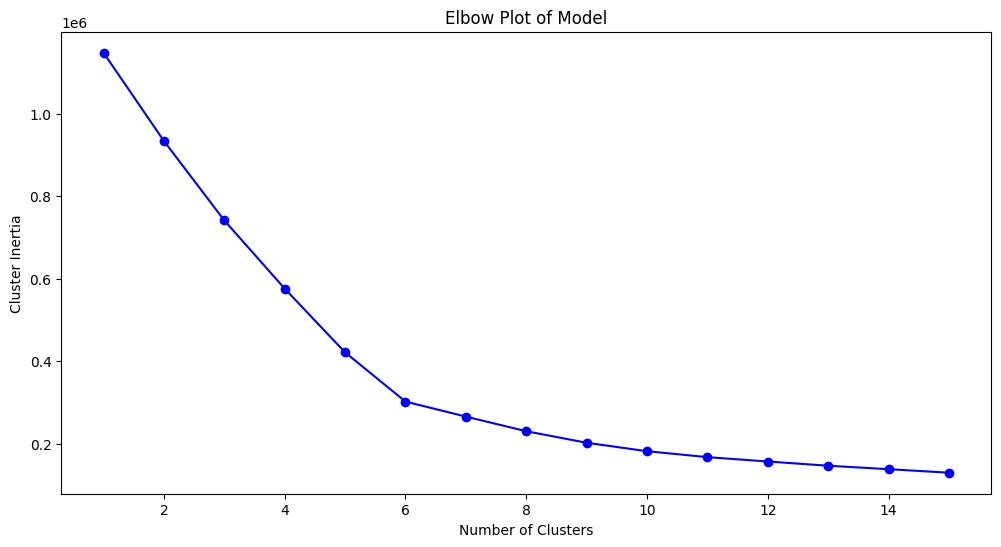

In [58]:
clusters_centers, k_values = find_optimal_clusters(g_company_type_df[feature_columns], 16)
generate_elbow_plot(clusters_centers, k_values)

> Putting Into K-means Model

In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [63]:
kmeans = KMeans(n_clusters=6, random_state=42)  # initialize the k-means model by using the optimal number of clusters found in the elbow method
kmeans.fit(X_train)                             # fit the k-means model to the training data
train_clusters = kmeans.predict(X_train)        # predict the clusters for the training data

c:\Users\emirh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# calculating the silhouette score for the training data where X_train is trained data and train_clusters are the labels
silhouette_train = silhouette_score(X_train, train_clusters)

# print the silhouette score
print("Silhouette Score (Training):", silhouette_train)